# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls /content/drive/My\ Drive/Colab\ Notebooks

database.sqlite  KNN.ipynb  Reviews.csv  Untitled2.ipynb
DT.ipynb	 NB.ipynb   SVM.ipynb


In [0]:
data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Reviews.csv')

In [0]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
conn=sqlite3.connect('/content/drive/My Drive/Colab Notebooks/database.sqlite')

In [0]:
filter_data=pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""",conn)

In [0]:
def partition (x):
  if x<3:
    return 0
  return 1

In [0]:
actualscore = filter_data['Score']
positivenegative = actualscore.map(partition)
filter_data['Score']= positivenegative
print('Nomber of data points in our data',filter_data.shape)
filter_data.head(5)

Nomber of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", conn)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

# [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", conn)
print(display.shape)
display.head()

(5, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filter_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filter_data['Id'].size*1.0)*100

87.775

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", conn)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

## [3] Preprocessing

### [3.1]. Preprocessing Review Text

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:34<00:00, 2553.35it/s]


In [0]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW

In [0]:
X=preprocessed_reviews
y=np.array(final['Score'])

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

count_vect = CountVectorizer()
count_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train =count_vect.transform(X_train)
X_cv = count_vect.transform(X_cv)
X_test = count_vect.transform(X_test)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

X_cv = preprocessing.normalize(X_cv)
print("CV Data Size :", X_cv.shape)

Train Data Size:  (56174, 44411)
Test Data Size:  (17555, 44411)
CV Data Size : (14044, 44411)


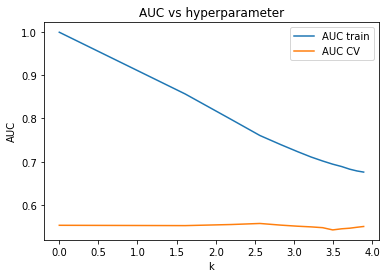

optimal alpha for which auc is maximum :  13


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import math

k = list(range(1,50,4))

train_auc = []
cv_auc = []

for i in k:
    clf = KNeighborsClassifier(n_neighbors = i,algorithm='brute')
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_k = k[cv_auc.index(max(cv_auc))]
k = [math.log(x) for x in k]

#plot auc vs alpha
x = plt.subplot( )
x.plot(k, train_auc, label='AUC train')
x.plot(k, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('k')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_k)


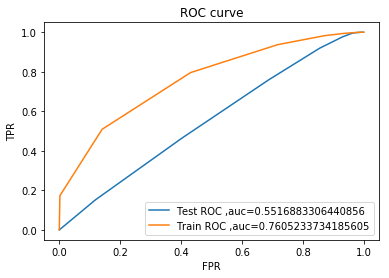

AUC on Test data is 0.5516883306440856
AUC on Train data is 0.7605233734185605
---------------------------


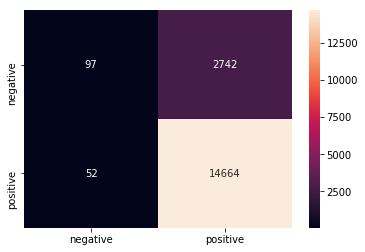

In [0]:
#Testing AUC on Test data
clf = KNeighborsClassifier(n_neighbors = optimal_k,algorithm='brute')
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
import pandas as pd
results=pd.DataFrame(columns=['Featuraization', 'algorithm' ,'k', 'Train-AUC', 'Test-AUC' ])
new = ['BOW','Brute',13,0.7605,0.5516]
results.loc[0] = new

### [5.1.2] Applying KNN brute force on TFIDF

In [0]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train = tf_idf_vect.transform(X_train)
X_cv = tf_idf_vect.transform(X_cv)
X_test = tf_idf_vect.transform(X_test)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

X_cv = preprocessing.normalize(X_cv)
print("CV Data Size :", X_cv.shape)

Train Data Size:  (56174, 33512)
Test Data Size:  (17555, 33512)
CV Data Size : (14044, 33512)


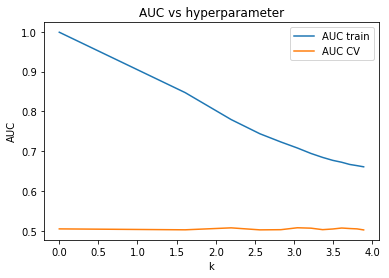

optimal alpha for which auc is maximum :  21


In [0]:
k = list(range(1,50,4))

train_auc = []
cv_auc = []

for i in k:
    clf = KNeighborsClassifier(n_neighbors = i,algorithm='brute')
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_k = k[cv_auc.index(max(cv_auc))]
k = [math.log(x) for x in k]

#plot auc vs alpha
x = plt.subplot( )
x.plot(k, train_auc, label='AUC train')
x.plot(k, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('k')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_k)

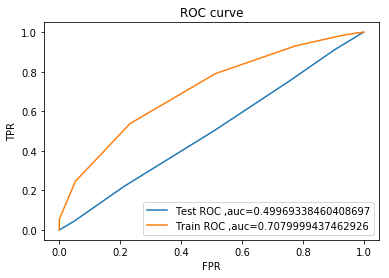

AUC on Test data is 0.49969338460408697
AUC on Train data is 0.7079999437462926
---------------------------


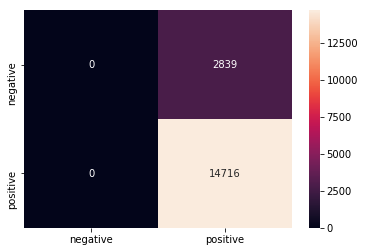

In [0]:
#Testing AUC on Test data
clf = KNeighborsClassifier(n_neighbors = optimal_k,algorithm='brute')
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
new = ['tf-idf','Brute',21,0.7079,0.4996]
results.loc[1] = new

### [5.1.3] Applying KNN brute force on AVG W2V

In [0]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 56174/56174 [01:47<00:00, 523.45it/s]

56174
50


In [0]:
#for cross validation we can use same w2v models and w2v words
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv = []; 
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))   

100%|██████████| 14044/14044 [00:26<00:00, 520.72it/s]

14044
50


In [0]:
#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
sent_vectors_test = []; 
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|██████████| 17555/17555 [00:33<00:00, 530.18it/s]

17555
50


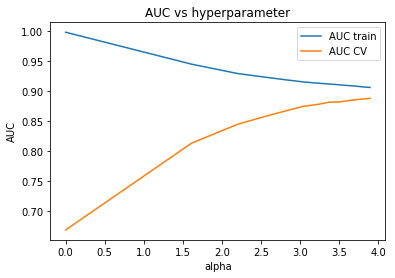

optimal alpha for which auc is maximum :  49


In [0]:
X_train = sent_vectors_train
X_cv = sent_vectors_cv
X_test = sent_vectors_test

k = list(range(1,50,4))

train_auc = []
cv_auc = []

for i in k:
    clf = KNeighborsClassifier(n_neighbors = i,algorithm='brute')
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_k = k[cv_auc.index(max(cv_auc))]
k = [math.log(x) for x in k]

#plot auc vs alpha
x = plt.subplot( )
x.plot(k, train_auc, label='AUC train')
x.plot(k, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_k)

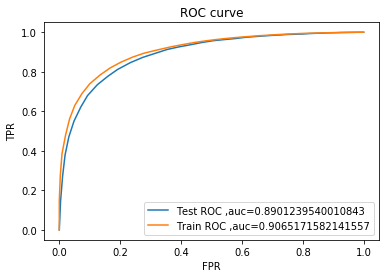

AUC on Test data is 0.8901239540010843
AUC on Train data is 0.9065171582141557
---------------------------


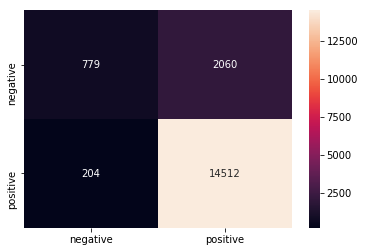

In [0]:
#Testing AUC on Test data
clf = KNeighborsClassifier(n_neighbors = optimal_k,algorithm='brute')
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
new = ['AVG W2V','Brute',49,0.9065,0.8901]
results.loc[2] = new

### [5.1.4] Applying KNN brute force on TFIDF W2V

In [0]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)


list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)

tf_idf_matrix=tf_idf_vect.fit_transform(X_train)


tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 56174/56174 [02:15<00:00, 415.95it/s]


In [0]:
#for cross validation data and test we will use same words and models of train
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_sent_vectors_cv = []; 
row=0;
for sent in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 14044/14044 [00:34<00:00, 409.90it/s]


In [0]:
#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_sent_vectors_test = []; 
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 17555/17555 [00:42<00:00, 413.21it/s]


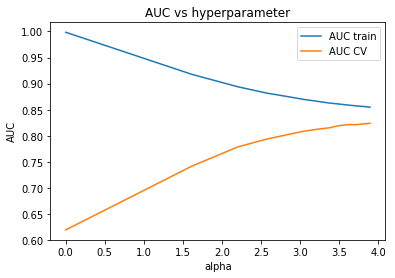

optimal alpha for which auc is maximum :  49


In [0]:
X_train = tfidf_sent_vectors_train
X_cv = tfidf_sent_vectors_cv
X_test = tfidf_sent_vectors_test

k = list(range(1,50,4))

train_auc = []
cv_auc = []

for i in k:
    clf = KNeighborsClassifier(n_neighbors = i,algorithm='brute')
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_k = k[cv_auc.index(max(cv_auc))]
k = [math.log(x) for x in k]

#plot auc vs alpha
x = plt.subplot( )
x.plot(k, train_auc, label='AUC train')
x.plot(k, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_k)

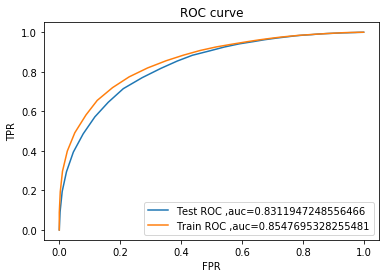

AUC on Test data is 0.8311947248556466
AUC on Train data is 0.8547695328255481
---------------------------


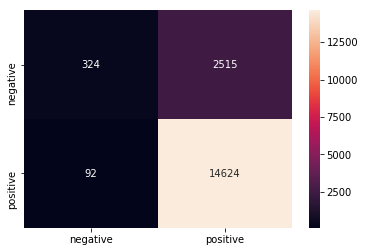

In [0]:
#Testing AUC on Test data
clf = KNeighborsClassifier(n_neighbors = optimal_k,algorithm='brute')
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
new = ['tf-idf W2V','Brute',49,0.8547,0.8311]
results.loc[3] = new

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW

In [0]:
X=preprocessed_reviews
y=np.array(final['Score'])
X=X[:50000]
y=y[:50000]

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

count_vect = CountVectorizer(min_df=10, max_features=500)
count_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train =count_vect.transform(X_train)
X_cv = count_vect.transform(X_cv)
X_test = count_vect.transform(X_test)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

X_cv = preprocessing.normalize(X_cv)
print("CV Data Size :", X_cv.shape)

Train Data Size:  (32000, 500)
Test Data Size:  (10000, 500)
CV Data Size : (8000, 500)


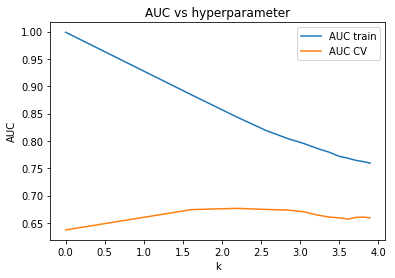

optimal alpha for which auc is maximum :  9


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import math

k = list(range(1,50,4))

train_auc = []
cv_auc = []

for i in k:
    clf = KNeighborsClassifier(n_neighbors = i,algorithm='kd_tree')
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_k = k[cv_auc.index(max(cv_auc))]
k = [math.log(x) for x in k]

#plot auc vs alpha
x = plt.subplot( )
x.plot(k, train_auc, label='AUC train')
x.plot(k, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('k')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_k)


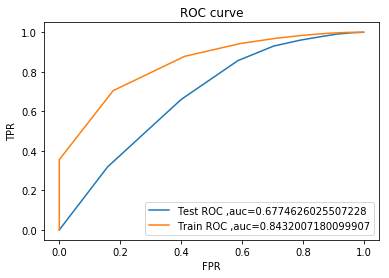

AUC on Test data is 0.6774626025507228
AUC on Train data is 0.8432007180099907
---------------------------


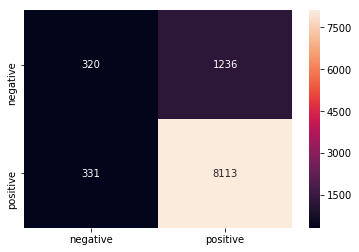

In [0]:
#Testing AUC on Test data
clf = KNeighborsClassifier(n_neighbors = optimal_k,algorithm='kd_tree')
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
results_1=pd.DataFrame(columns=['Featuraization', 'algorithm' ,'k', 'Train-AUC', 'Test-AUC' ])
new = ['BOW','kd_tree',9,0.8432,0.6774]
results_1.loc[0] = new

### [5.2.2] Applying KNN kd-tree on TFIDF

In [0]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train = tf_idf_vect.transform(X_train)
X_cv = tf_idf_vect.transform(X_cv)
X_test = tf_idf_vect.transform(X_test)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

X_cv = preprocessing.normalize(X_cv)
print("CV Data Size :", X_cv.shape)

Train Data Size:  (32000, 500)
Test Data Size:  (10000, 500)
CV Data Size : (8000, 500)


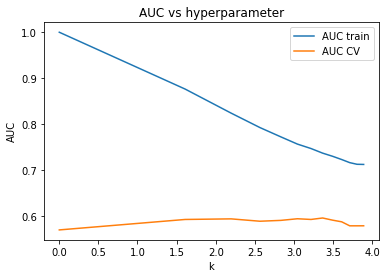

optimal alpha for which auc is maximum :  29


In [0]:
k = list(range(1,50,4))

train_auc = []
cv_auc = []

for i in k:
    clf = KNeighborsClassifier(n_neighbors = i,algorithm='kd_tree')
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_k = k[cv_auc.index(max(cv_auc))]
k = [math.log(x) for x in k]

#plot auc vs alpha
x = plt.subplot( )
x.plot(k, train_auc, label='AUC train')
x.plot(k, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('k')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_k)


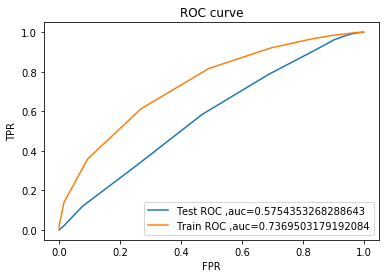

AUC on Test data is 0.5754353268288643
AUC on Train data is 0.7369503179192084
---------------------------


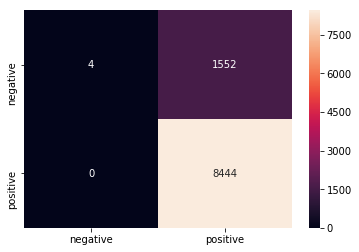

In [0]:
#Testing AUC on Test data
clf = KNeighborsClassifier(n_neighbors = optimal_k,algorithm='kd_tree')
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
new = ['tf-idf','kd_tree',29,0.7369,0.5754]
results_1.loc[1] = new

### [5.2.3] Applying KNN kd-tree on AVG W2V

In [0]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 32000/32000 [00:57<00:00, 559.59it/s]

32000
50


In [0]:
#for cross validation we can use same w2v models and w2v words
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv = []; 
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))   

100%|██████████| 8000/8000 [00:14<00:00, 535.50it/s]

8000
50


In [0]:
#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
sent_vectors_test = []; 
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|██████████| 10000/10000 [00:18<00:00, 542.77it/s]

10000
50


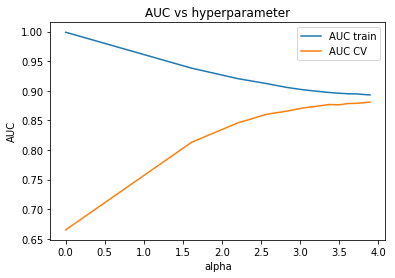

optimal alpha for which auc is maximum :  49


In [0]:
X_train = sent_vectors_train
X_cv = sent_vectors_cv
X_test = sent_vectors_test

k = list(range(1,50,4))

train_auc = []
cv_auc = []

for i in k:
    clf = KNeighborsClassifier(n_neighbors = i,algorithm='kd_tree')
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_k = k[cv_auc.index(max(cv_auc))]
k = [math.log(x) for x in k]

#plot auc vs alpha
x = plt.subplot( )
x.plot(k, train_auc, label='AUC train')
x.plot(k, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_k)

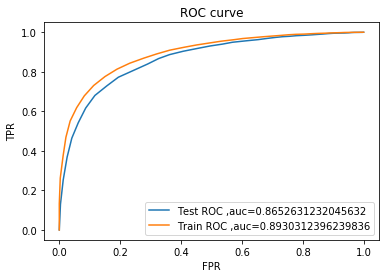

AUC on Test data is 0.8652631232045632
AUC on Train data is 0.8930312396239836
---------------------------


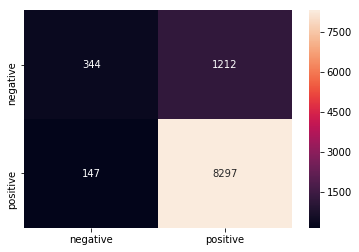

In [0]:
#Testing AUC on Test data
clf = KNeighborsClassifier(n_neighbors = optimal_k,algorithm='kd_tree')
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
new = ['AVG W2V','kd_tree',49,0.8652,0.8930]
results_1.loc[2] = new

### [5.2.4] Applying KNN kd-tree on TFIDF W2V

In [0]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)


list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)

tf_idf_matrix=tf_idf_vect.fit_transform(X_train)


tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 32000/32000 [01:17<00:00, 413.58it/s]


In [0]:
#for cross validation data and test we will use same words and models of train
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_sent_vectors_cv = []; 
row=0;
for sent in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 8000/8000 [00:20<00:00, 399.61it/s]


In [0]:
#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_sent_vectors_test = []; 
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 10000/10000 [00:25<00:00, 398.90it/s]


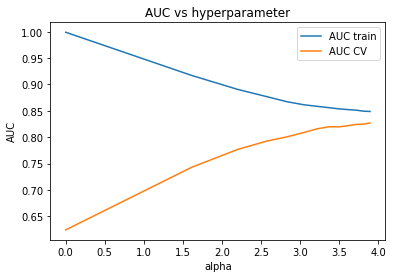

optimal alpha for which auc is maximum :  49


In [0]:
X_train = tfidf_sent_vectors_train
X_cv = tfidf_sent_vectors_cv
X_test = tfidf_sent_vectors_test

k = list(range(1,50,4))

train_auc = []
cv_auc = []

for i in k:
    clf = KNeighborsClassifier(n_neighbors = i,algorithm='kd_tree')
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_k = k[cv_auc.index(max(cv_auc))]
k = [math.log(x) for x in k]

#plot auc vs alpha
x = plt.subplot( )
x.plot(k, train_auc, label='AUC train')
x.plot(k, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_k)

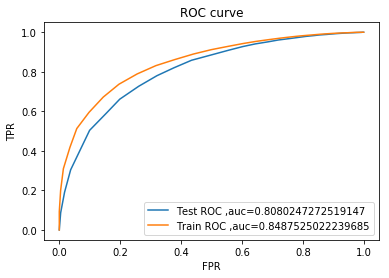

AUC on Test data is 0.8080247272519147
AUC on Train data is 0.8487525022239685
---------------------------


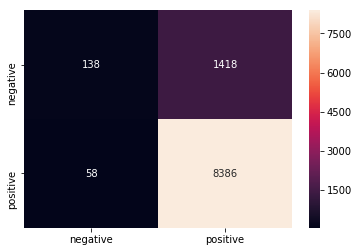

In [0]:
#Testing AUC on Test data
clf = KNeighborsClassifier(n_neighbors = optimal_k,algorithm='kd_tree')
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train)

#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
new = ['tf-idf W2V','kd_tree',49,0.8487,0.8080]
results_1.loc[3] = new

### Performance Table

In [0]:
results

,Featuraization,algorithm,k,Train-AUC,Test-AUC
0,BOW,Brute,13,0.7605,0.5516
1,tf-idf,Brute,21,0.7079,0.4996
2,AVG W2V,Brute,49,0.9065,0.8901
3,tf-idf W2V,Brute,49,0.8547,0.8311


In [0]:
results_1

,Featuraization,algorithm,k,Train-AUC,Test-AUC
0,BOW,kd_tree,9,0.8432,0.6774
1,tf-idf,kd_tree,29,0.7369,0.5754
2,AVG W2V,kd_tree,49,0.8652,0.8930
3,tf-idf W2V,kd_tree,49,0.8487,0.8080


# [6] Conclusions

1. KNN is the one of the best algorithm

2. KNN kd_tree  gave best results better then Brute force
 
3. Training time for kd_tree is high compred to brute force algorithm
 
4. Kd_tree with AVG W2V featuraization and k = 49 gave best AUC Score = 0.8930